## Домашнее задание 4
* Сравнить LSTM, RNN и GRU на задаче предсказания части речи (качество предсказания, скорость обучения, время инференса модели)
* *к первой задаче добавить bidirectional

In [15]:
import time
import warnings
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import numpy as np
from os.path import exists
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score

In [16]:
class DatasetSeq(Dataset):
    def __init__(self, data_dir, train_lang='en'):
	#open file
        with open(data_dir + train_lang + '.train', 'r') as f:
            train = f.read().split('\n\n')

        # delete extra tag markup
        train = [x for x in train if not '_ ' in x]
	    #init vocabs of tokens for encoding { token:  id}
        self.target_vocab = {} # {p: 1, a: 2, r: 3, pu: 4}
        self.word_vocab = {} # {cat: 1, sat: 2, on: 3, mat: 4, '.': 5}
        self.char_vocab = {} # {c: 1, a: 2, t: 3, ' ': 4, s: 5}
	    
        # Cat sat on mat. -> [1, 2, 3, 4, 5]
        # p    a  r  p pu -> [1, 2, 3, 1, 4]
        # chars  -> [1, 2, 3, 4, 5, 2, 3, 4]

	    #init encoded sequences lists (processed data)
        self.encoded_sequences = []
        self.encoded_targets = []
        self.encoded_char_sequences = []
        # n=1 because first value is padding
        n_word = 1
        n_target = 1
        n_char = 1
        for line in train:
            sequence = []
            target = []
            chars = []
            for item in line.split('\n'):
                if item != '':
                    word, label = item.split(' ')

                    if self.word_vocab.get(word) is None:
                        self.word_vocab[word] = n_word
                        n_word += 1
                    if self.target_vocab.get(label) is None:
                        self.target_vocab[label] = n_target
                        n_target += 1
                    for char in word:
                        if self.char_vocab.get(char) is None:
                            self.char_vocab[char] = n_char
                            n_char += 1
                    sequence.append(self.word_vocab[word])
                    target.append(self.target_vocab[label])
                    chars.append([self.char_vocab[char] for char in word])
            self.encoded_sequences.append(sequence)
            self.encoded_targets.append(target)
            self.encoded_char_sequences.append(chars)

    def __len__(self):
        return len(self.encoded_sequences)

    def __getitem__(self, index):
        return {
            'data': self.encoded_sequences[index], # [1, 2, 3, 4, 6] len=5
            'char': self.encoded_char_sequences[index],# [[1,2,3], [4,5], [1,2], [2,6,5,4], []] len=5
            'target': self.encoded_targets[index], #  (1)
        }

dataset = DatasetSeq('')        

In [17]:
def collate_fn(batch):
    data = []
    target = []
    for item in batch:
        data.append(torch.as_tensor(item['data']))
        target.append(torch.as_tensor(item['target']))
    data = pad_sequence(data, batch_first=True, padding_value=0)
    target = pad_sequence(target, batch_first=True, padding_value=0)

    return {'data': data, 'target': target}
     

In [18]:

class RNNPredictorV2(nn.Module):
    # ну я тут добавил параметр, которым будет задаваться класс, модель с которым нам нужно создать
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes, cl):
        super().__init__()
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # соответственно здесь - инициируется как раз объект этого класса, то есть модель в каждом случае  будет разная
        self.rnn = cl(emb_dim, hidden_dim, batch_first=True)
        self.clf = nn.Linear(hidden_dim, n_classes)
        self.do = nn.Dropout(0.1)
    
    def forward(self, x):
        emb = self.word_emb(x) # B x T x Emb_dim
        hidden, _ = self.rnn(emb) # B x T x Hid, B x 1 x Hid
        pred = self.clf(self.do(hidden)) # B x T x N_classes

        return pred

In [19]:
#hyper params
vocab_size = len(dataset.word_vocab) + 1
n_classes = len(dataset.target_vocab) + 1
n_chars = len(dataset.char_vocab) + 1
#TODO try to use other model parameters
emb_dim = 128
hidden = 128
n_epochs = 10
batch_size = 100
device = 'cpu'

In [20]:
# здесь я формирую три объекта модели и соответсвующего оптимизатора
model_rnn = RNNPredictorV2(vocab_size, emb_dim, hidden, n_classes, nn.RNN).to(device)
model_rnn.train()
optim_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

model_lstm = RNNPredictorV2(vocab_size, emb_dim, hidden, n_classes, nn.LSTM).to(device)
model_lstm.train()
optim_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

model_gru = RNNPredictorV2(vocab_size, emb_dim, hidden, n_classes, nn.GRU).to(device)
model_gru.train()
optim_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [21]:
epoch_stats_df = pd.DataFrame(columns=['Epoch','RNN', 'LSTM', 'GRU'])

In [22]:
dataloader = DataLoader(dataset, batch_size, shuffle=False, collate_fn=collate_fn, drop_last = True)
print(len(dataloader))
test_dataset = list()
if exists('learning_stats.pickle'):
    for i, batch in enumerate(dataloader):
        if i>200:
            test_dataset.append((i,batch))


212


In [23]:
# служебный класс для прогона "эпохи"
def process_epoch(model: nn.Module, optimizer: torch.optim.Optimizer):
    time_before = time.time()
    for i, batch in enumerate(dataloader):
        if i <= 200:
            optimizer.zero_grad()
            predict = model(batch['data'].to(device))
            loss = loss_func(predict.view(-1, n_classes),
                             batch['target'].to(device).view(-1),
                           )
            loss.backward()
            optimizer.step()
        elif epoch==0:
            test_dataset.append((i,batch)) # оставляю кусок датасета для замера времени инференса и подсчета качества каждой модели.  батчи [201-212] буду использовать для теста
    time_after = time.time()
    return time_after-time_before

if not exists('learning_stats.pickle'):
# обучающий цикл. он будет один, за одну эпоху обучаем все три модели. продолжительность эпохи длякаджой модели записываем в датафрейм
    for epoch in range(n_epochs):
        ### rnn
        rnn_epoch_duration = process_epoch(model_rnn, optim_rnn)
        lstm_epoch_duration = process_epoch(model_lstm, optim_lstm)
        gru_epoch_duration = process_epoch(model_gru, optim_gru)
        print(f'rnn epoch:{epoch}| rnn: {rnn_epoch_duration}, lstm epoch: {lstm_epoch_duration}, gru: {gru_epoch_duration}')
        epoch_stats_df = epoch_stats_df.append({'Epoch': epoch, 'RNN':rnn_epoch_duration, 'LSTM':lstm_epoch_duration, 'GRU':gru_epoch_duration},ignore_index=True)
        torch.save(model_rnn, 'my_rnn_model.pickle')
        torch.save(model_lstm, 'my_lstm_model.pickle')
        torch.save(model_gru, 'my_gru_model.pickle')

        epoch_stats_df.to_pickle('learning_stats.pickle')
else:
    epoch_stats_df = pd.read_pickle('learning_stats.pickle')
    model_rnn = torch.load('my_rnn_model.pickle')
    model_lstm = torch.load('my_lstm_model.pickle')
    model_gru = torch.load('my_gru_model.pickle')
    
print('here is dataframe with epoch epochs statistics')



rnn epoch:0| rnn: 5.376127004623413, lstm epoch: 11.591525077819824, gru: 10.183023929595947
rnn epoch:1| rnn: 5.603142261505127, lstm epoch: 11.50241494178772, gru: 10.002900123596191
rnn epoch:2| rnn: 5.598433971405029, lstm epoch: 11.477622985839844, gru: 10.011725902557373
rnn epoch:3| rnn: 5.538758039474487, lstm epoch: 11.525661945343018, gru: 10.049337148666382
rnn epoch:4| rnn: 5.6333417892456055, lstm epoch: 11.656707048416138, gru: 10.13768196105957
rnn epoch:5| rnn: 5.69238805770874, lstm epoch: 11.673913955688477, gru: 10.19636607170105
rnn epoch:6| rnn: 5.726492881774902, lstm epoch: 11.643841743469238, gru: 10.178048849105835
rnn epoch:7| rnn: 5.6503260135650635, lstm epoch: 11.667803764343262, gru: 10.209052801132202
rnn epoch:8| rnn: 5.667370080947876, lstm epoch: 11.696340084075928, gru: 10.227772235870361
rnn epoch:9| rnn: 5.741461992263794, lstm epoch: 11.692317247390747, gru: 10.181402921676636
here is dataframe with epoch epochs statistics


In [24]:
epoch_stats_df

,Epoch,RNN,LSTM,GRU
0,0.0,5.376127,11.591525,10.183024
1,1.0,5.603142,11.502415,10.002900
2,2.0,5.598434,11.477623,10.011726
3,3.0,5.538758,11.525662,10.049337
4,4.0,5.633342,11.656707,10.137682
5,5.0,5.692388,11.673914,10.196366
6,6.0,5.726493,11.643842,10.178049
7,7.0,5.650326,11.667804,10.209053
8,8.0,5.667370,11.696340,10.227772
9,9.0,5.741462,11.692317,10.181403


<AxesSubplot:title={'center':'Статистика времени обучения'}, xlabel='Epoch'>

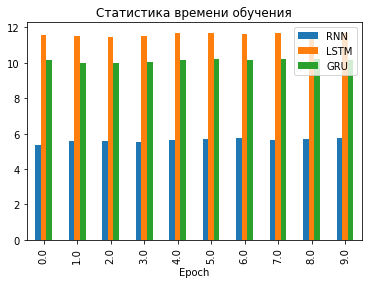

In [25]:
epoch_stats_df_with_index = epoch_stats_df.set_index('Epoch')
epoch_stats_df_with_index.plot(title = 'Статистика времени обучения', kind='bar' )


In [26]:
len(test_dataset)

33

In [27]:
loss_func = nn.L1Loss()

def measure_inference_time(model: nn.Module, test_dataset: list):
    result = np.zeros(len(test_dataset))
    result_r2 = np.zeros(len(test_dataset))
    model.eval()
    numpy_index = 0
    for i, batch in test_dataset:
        time_bef = time.time()
        cur_res = model(batch['data'].to(device))
        exp_res = batch['target']
        cur_res = torch.argmax(cur_res, dim=2)
        r2 = r2_score(exp_res, cur_res)
        result_r2[numpy_index] = r2
        time_aft = time.time()
        time_diff = time_aft - time_bef
        result[numpy_index] = time_diff
        numpy_index+=1
    return np.average(result), np.average(result_r2)

In [28]:
rnn_res = measure_inference_time(model_rnn, test_dataset)
inference_rnn = rnn_res[0]
r2_rnn = rnn_res[1]
lstm_res = measure_inference_time(model_lstm, test_dataset)
inference_lstm = lstm_res[0]
r2_lstm = lstm_res[1]
gru_res = measure_inference_time(model_gru, test_dataset)
inference_gru = gru_res[0]
r2_gru = gru_res[1]

print('Here is some statistics of model\'s inference time: ')
print(f'rnn: {inference_rnn}')
print(f'lstm: {inference_lstm}')
print(f'gru: {inference_gru}')

print('Here is some statistic about quality of difference models (comparing by r2_score):')
print(f'rnn r2: {r2_rnn}')
print(f'lstm_r2: {r2_lstm}')
print(f'gru_r2: {r2_gru}')

Here is some statistics of model's inference time: 
rnn: 0.009104873194839016
lstm: 0.025652191855690697
gru: 0.02012793223063151
Here is some statistic about quality of difference models (comparing by r2_score):
rnn r2: 0.7834413924168729
lstm_r2: 0.83373787557998
gru_r2: 0.601522692628728
